# Environment Setup

Mount Drive

Navigate to data/audio

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

%cd "/content/drive/My Drive/data/audio"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/data/audio


Check GPU connection

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Install additional packages (e.g. librosa)

In [3]:
!pip install librosa

    100% |████████████████████████████████| 1.6MB 8.0MB/s 
    100% |████████████████████████████████| 327kB 11.0MB/s 
    100% |████████████████████████████████| 3.2MB 7.6MB/s 
    100% |████████████████████████████████| 16.1MB 1.6MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [4]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import random
import glob
import re
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# Data Exploration

Example of spectrograms of different meters

Clearly there is some difference in structure in melspectrograms

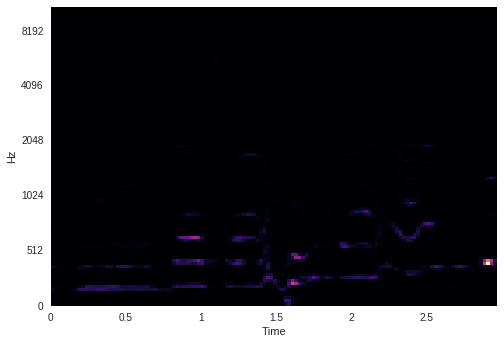

In [5]:
# Example of spectrogram
y, sr = librosa.load('01_10003_1-04_Shri_Visvanatham.wav',
                     offset = 25.0, duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time');

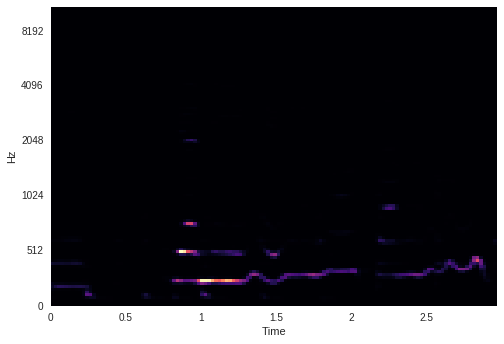

In [6]:
# Example of spectrogram
y, sr = librosa.load('01_11001_3_Sankari_Neeve.wav',
                     offset = 45.00, duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

# Data Preprocessing

Extract song names and corresponding meters

Encode song meters to integers for classifier

**model and preprocessing code largely based on:**
*   Code Emporium on YouTube: *Sound Play with Convolution Neural Networks*
*   Code Emporium's (Ajay Halthor) code on GitHub: *audio-classifier-convNet*
*   arXiv paper for model specification: https://arxiv.org/pdf/1608.04363.pdf (by *Justin Salamon and Juan Pablo Bello at MARL/CUSP at NYU*)


In [7]:
# Extract song names
songs = [re.search('.+?(?=\.wav)', x).group(0)
              for x in glob.iglob('*.wav')]
# Extract song meter
meter = []
for song in songs:
    with open('../annotations/meter/' + song + '.meter', 'r') as file:
        meter.append(file.readline())

# Encode song meter to integer
le = LabelEncoder()
meter_enc = le.fit_transform(meter)
meter[:5] , meter_enc[:5], songs[:5]
len(meter_enc), len(songs)


(118, 118)

In [8]:
song_meter = list(zip(songs, meter_enc))

random.shuffle(song_meter)

train = song_meter[:90]
test = song_meter[90:]

songs_train, meter_train =  zip(*train)
songs_test, meter_test = zip(*test)

songs_train[:5] , songs_test[:5]
len(songs_train), len(songs_test)




(90, 28)

In [10]:
D_train = []

for i, song in enumerate(songs_train):
    print(i) #comment out to hide verbose output
    for j in range(60):
        y, sr = librosa.load(song + '.wav', 
                             offset = np.random.randint(10, 80),
                             duration=2.97)  
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D_train.append( (song, ps, meter_train[i]) )
        
D_test = []        
for i, song in enumerate(songs_test):
    print(i) #comment out to hide verbose output
    for j in range(60):
        y, sr = librosa.load(song + '.wav', 
                             offset = np.random.randint(10, 80),
                             duration=2.97)  
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D_test.append( (song, ps, meter_test[i]) )


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


Create dataset as list of tuples -- (song name, melspectrogram array, meter encoding)

Created random melspec snapshots of ~3s b/w 10s and 80s of each song

\# of random melspec snapshots (30) affects total sample size = # snapshots * # songs

Takes long time (and memory!) to build dataset --> bottle neck of script

Improvements:

*   Create generator to feed in batches of training & validation data in real-tim
*   Preprocess data in a multicore manner



In [0]:
D = [] # Dataset

for i, song in enumerate(songs):
    print(i) #comment out to hide verbose output
    for j in range(10):
        y, sr = librosa.load(song + '.wav', 
                             offset = np.random.randint(10, 80),
                             duration=2.97)  
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (song, ps, meter_enc[i]) )
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [0]:
print("Number of samples: ", len(D))

Number of samples:  1180


In [11]:
print("Number of training samples: ", len(D_train))

print("Number of testing samples: ", len(D_test))


Number of training samples:  5400
Number of testing samples:  1680


Create train-test splits

Reshape features for CNN input

Create one-hot matrices for labels for CNN input

In [0]:
import copy

tmp1 = copy.deepcopy(D_train)
tmp2 = copy.deepcopy(D_test)



In [0]:
tmp[0]

('16_12028_2-01_Innamum',
 array([[8.01554866e-01, 1.94346059e-01, 1.11559526e-03, ...,
         1.70150549e-03, 1.01673861e-03, 1.48623540e+00],
        [1.15785673e+00, 2.95366661e-01, 3.65929972e-03, ...,
         5.01009588e-03, 4.09926987e-03, 1.64677319e+00],
        [1.79603285e+00, 4.70447088e-01, 6.96525482e-03, ...,
         1.25268877e-02, 9.88900440e-03, 1.75697206e+00],
        ...,
        [8.79534740e-04, 1.03743927e-03, 2.11696519e-03, ...,
         7.16995270e-04, 8.48048333e-04, 2.19927047e-03],
        [8.55181897e-04, 6.39363732e-04, 5.74754177e-04, ...,
         1.96707542e-04, 1.67288225e-04, 1.25232736e-03],
        [2.17273134e-04, 8.00381771e-05, 4.77669017e-05, ...,
         1.23884758e-05, 9.70013059e-06, 1.02497457e-03]]),
 2)

In [0]:
frac = 0.80
split = int(np.floor(len(D) * frac))

dataset = copy.deepcopy(D)
random.shuffle(dataset)

train = dataset[:split]
test = dataset[split:]

_, X_train, y_train = zip(*train)
_, X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 4))
y_test = np.array(keras.utils.to_categorical(y_test, 4))

In [0]:
dataset = copy.deepcopy(D)

train = dataset[:900]
test = dataset[900:]
random.shuffle(train)
random.shuffle(test)

_, X_train, y_train = zip(*train)
_, X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 4))
y_test = np.array(keras.utils.to_categorical(y_test, 4))

In [0]:
random.shuffle(D_train)
random.shuffle(D_test)

_, X_train, y_train = zip(*D_train)
_, X_test, y_test = zip(*D_test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 4))
y_test = np.array(keras.utils.to_categorical(y_test, 4))

Specity, compile, and evaluate model

Model based on *Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification*

> arXiv: https://arxiv.org/pdf/1608.04363.pdf

Improvements:

*   Modify model architecture, loss, and optimizer to improve model
*   Assess model performance on a variety of measure appropriate for multinomial classification problem
*   Compare model performance with different inputs: percussive only, harmonics only, both (current)




In [0]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('sigmoid'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('sigmoid'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('sigmoid'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dropout(rate=0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

In [18]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=100,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5400 samples, validate on 1680 samples
Epoch 1/100
5400/5400 [==============================] - 4s 711us/step - loss: 1.4300 - acc: 0.2565 - val_loss: 1.3995 - val_acc: 0.2143
Epoch 2/100
5400/5400 [==============================] - 3s 601us/step - loss: 1.3849 - acc: 0.2628 - val_loss: 1.3934 - val_acc: 0.2143
Epoch 3/100
5400/5400 [==============================] - 3s 595us/step - loss: 1.3854 - acc: 0.2646 - val_loss: 1.3938 - val_acc: 0.2143
Epoch 4/100
5400/5400 [==============================] - 3s 597us/step - loss: 1.3855 - acc: 0.2689 - val_loss: 1.3948 - val_acc: 0.2143
Epoch 5/100
5400/5400 [==============================] - 3s 601us/step - loss: 1.3855 - acc: 0.2670 - val_loss: 1.3932 - val_acc: 0.2143
Epoch 6/100
5400/5400 [==============================] - 3s 600us/step - loss: 1.3847 - acc: 0.2696 - val_loss: 1.3945 - val_acc: 0.2143
Epoch 7/100
5400/5400 [==============================] - 3s 603us/step - loss: 1.3843 - acc: 0.2707 - val_loss: 1.3952 - val_acc: 

We can also augment data as show in YT video to imrpove model performance... (shown below for Ajay's dataset)

In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import cv2

D_train_v3 = []
for x in D_train:
  tmp_v3 = cv2.merge((x[1],x[1],x[1]))
  tmp_v3 = preprocess_input(tmp_v3)
  D_train_v3.append( (x[0], tmp_v3, x[2]) )

D_test_v3 = []
for x in D_test:
  tmp_v3 = cv2.merge((x[1],x[1],x[1]))
  tmp_v3 = preprocess_input(tmp_v3)
  D_test_v3.append( (x[0], tmp_v3, x[2]) )


In [1]:
random.shuffle(D_train_v3)
random.shuffle(D_test_v3)

_, X_train, y_train = zip(*D_train_v3)
_, X_test, y_test = zip(*D_test_v3)


# Reshape for CNN input
X_train = np.array(X_train)
X_test = np.array(X_test)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 4))
y_test = np.array(keras.utils.to_categorical(y_test, 4))

NameError: ignored

In [48]:
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


for layer in model.layers:
   layer.trainable = True

# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',  metrics=['accuracy'])
       
# train the model on the new data for a few epochs
#model.fit_generator(generator(x_train, y_train, 5), steps_per_epoch=16, epochs=20)

model.fit(X_train, y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 5400 samples, validate on 1680 samples
Epoch 1/25
5400/5400 [==============================] - 51s 9ms/step - loss: 1.4600 - acc: 0.2630 - val_loss: 1.4651 - val_acc: 0.2411
Epoch 2/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.3873 - acc: 0.3089 - val_loss: 1.4987 - val_acc: 0.2304
Epoch 3/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.3472 - acc: 0.3367 - val_loss: 1.4711 - val_acc: 0.2571
Epoch 4/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.3086 - acc: 0.3676 - val_loss: 1.4628 - val_acc: 0.2232
Epoch 5/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.2612 - acc: 0.4094 - val_loss: 1.4515 - val_acc: 0.2500
Epoch 6/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.2311 - acc: 0.4439 - val_loss: 1.5782 - val_acc: 0.2179
Epoch 7/25
5400/5400 [==============================] - 33s 6ms/step - loss: 1.1878 - acc: 0.4861 - val_loss: 1.4977 - val_acc: 0.2387
Epoch 8

## Data Augmentation

### 1. Vary Time

In [0]:
y, sr = librosa.load('code/UrbanSound8K/audio/fold1/14113-4-0-1.wav', duration=2.97)
y_changed = librosa.effects.time_stretch(y, rate=0.81)
librosa.output.write_wav('code/augmented/fold1/speed_81/14113-4-0-1.wav' ,y_changed, sr)

In [0]:
rate = 1.07 # replace with 0.81 and execute again

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/' + row.slice_file_name ,y_changed, sr)

### 2. Vary pitch

In [0]:
n_steps = 2 #-1, -2, 2, 1

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/' + row.slice_file_name ,y_changed, sr)

### 3. Change Pitch (PS2)

In [0]:
n_steps = 2.5 #-2.5, -3.5, 2.5, 3.5

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path) 
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/ps2_m' + str(int(n_steps*10)) + '/' + row.slice_file_name ,y_changed, sr)

Accidently put ps2_25 files in ps2_m25. 

In [0]:
len(D)

The dataset consists of:
- 1-7467 normal samples.
- 7468-14934 samples Pitch modulated 2.5 semitones higher.
- 14935-22401 samples Pitch modeulated 2 semitones higher.
- 22402-29869 samples Slowed down to 0.81.
- 29869-37310 samples speed up by 1.07

Follow the same procedure for the normal data.

In [0]:
dataset = D
random.shuffle(dataset)

train = dataset[:35000]
test = dataset[35000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [0]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

With data augmentation, we get upto $82\%$. 